In [1]:
from matplotlib import pyplot as plt

import xarray as xr
import netCDF4 as nc
import numpy as np

import os

import datetime as dt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, Ridge, LinearRegression, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
import random
from tqdm import tqdm
from collections import Counter

In [2]:
models = ['CanESM5', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'MIROC6', 'CESM2']

In [3]:
def load_model_data(model, var, path='../data/'):
    # Loading data file
    file_path = os.path.join(path, '{}_{}.nc'.format(model, var))
    ds = xr.open_dataset(file_path)
    # Getting TAS
    tas_array = ds[var].values
    # Close the dataset
    ds.close()
    return tas_array

def get_data_shape_lat_lon(model='CanESM5', var='tas', path='../data/'):
    file_path = os.path.join(path, '{}_{}.nc'.format(model, var))
    ds = xr.open_dataset(file_path)
    # Getting TAS
    shape = ds[var].values.shape
    # Close the dataset
    ds.close()
    return shape, ds['lat'], ds['lon']

def load_data_models(models, var='tas', n_sample=10, path='../data/', coarse=12):
    X, y = None, None
    for model in models:
        tas_array = load_model_data(model, var=var, path=path)
        shape = tas_array.shape
        
        idxs = random.sample(range(shape[0]*shape[1]), n_sample)
        X_temp = tas_array.reshape(shape[0]*shape[1], shape[2]//coarse, coarse, shape[3]//coarse, coarse).mean(axis=(2,4))
        X_temp = X_temp.reshape(shape[0]*shape[1], shape[2]*shape[3]//(coarse**2))
        y_temp = np.tile(tas_array.mean(axis=0), (shape[0], 1, 1)) .reshape(shape[0]*shape[1], shape[2]*shape[3])

        if X is None:
            X = X_temp[idxs,:]
            y = y_temp[idxs,:]
        else :
            X = np.vstack((X, X_temp[idxs,:]))
            y = np.vstack((y, y_temp[idxs,:]))
        del tas_array
        del X_temp
        del y_temp
    return X, y

In [4]:
shape, lat, lon = get_data_shape_lat_lon()
d = shape[2]*shape[3]

In [5]:
B = 10 
models_test = random.choices(models, k=B)
models_train = [[model for model in models if model != model_test ] for model_test in models_test ]

In [6]:
occurence_models_test = Counter(models_test)

In [7]:
occurence_models_test

Counter({'MPI-ESM1-2-LR': 3, 'CanESM5': 4, 'CESM2': 3})

In [10]:
N = 2500
n_alpha = 5
alphas = np.logspace(1, 3, n_alpha)
coarse = 6
n_cv = 3

In [9]:

weights = {model: None for model in models}
for i in tqdm(range(len(models_test))):
    m_train, m_test = models_train[i], models_test[i]
    #print('Fitting optimal ridge {}/{}'.format(i, B))
    print("Extracting data...", end='\r')
    X_train, Y_train = load_data_models(m_train, n_sample=N, coarse=coarse)
    X_test, Y_test = load_data_models([m_test], n_sample=N, coarse=coarse)
    print("Data extracted!")
    
    #idx = random.choices([0, 1, 2, 3])[0]
    #idx_val = list(range(idx*N, (idx+1)*N))
    #idx_train = list(list(range(0, idx*N))+ list(range(idx*N, 4*N)))
    print("Training ridge regression...", end='\r')
    ridge = RidgeCV(alphas=alphas, cv=n_cv) #cv=zip(idx_val, idx_val))
    ridge.fit(X_train, Y_train)
    print('Selected alpha : {}'.format(ridge.alpha_))
    print("Ridge regression fitted!")
    print('Saving weights...', end='\r')
    if weights[m_test] is None:
        weights[m_test] = np.hstack((ridge.coef_/occurence_models_test[m_test], (ridge.intercept_/occurence_models_test[m_test])[:,None]))
    else:
        weights[m_test] += np.hstack((ridge.coef_/occurence_models_test[m_test], (ridge.intercept_/occurence_models_test[m_test])[:,None]))
    print("Weights saved!")
# Save the weights for this alpha to a file
file_path = f'../weights/Ridge_weights_stability_n{N}_coarse{coarse}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(weights, f)

  0%|          | 0/10 [00:00<?, ?it/s]

Data extracted!...


 10%|█         | 1/10 [01:16<11:26, 76.24s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...


 20%|██        | 2/10 [02:42<10:55, 81.91s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...


 30%|███       | 3/10 [04:20<10:27, 89.65s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...


 40%|████      | 4/10 [05:43<08:39, 86.66s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...


 50%|█████     | 5/10 [07:02<07:00, 84.20s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...


 60%|██████    | 6/10 [08:27<05:36, 84.21s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...


 70%|███████   | 7/10 [09:51<04:12, 84.10s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...


 80%|████████  | 8/10 [11:14<02:47, 83.76s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...


 90%|█████████ | 9/10 [12:40<01:24, 84.75s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...


100%|██████████| 10/10 [14:01<00:00, 84.12s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...


In [11]:
directory = '../weights/'
file = 'Ridge_weights_stability_n{}_coarse{}.pkl'.format(N, coarse)
with open(directory + file, 'rb') as f:
    weights = pickle.load(f)

In [12]:
R = 10
scores_pattern = {model:[] for model in models}
for b in tqdm(range(R)):
    for model in models:
        X_test, Y_test = load_data_models([model], var='tas', coarse=coarse, n_sample=10)
        A, B = weights[model][:,:-1], weights[model][:,-1]
        Y_pred = X_test @ A.T + B 
        score_pattern = r2_score(Y_test, Y_pred, multioutput='raw_values')
        scores_pattern[model].append(score_pattern)


100%|██████████| 10/10 [08:36<00:00, 51.61s/it]


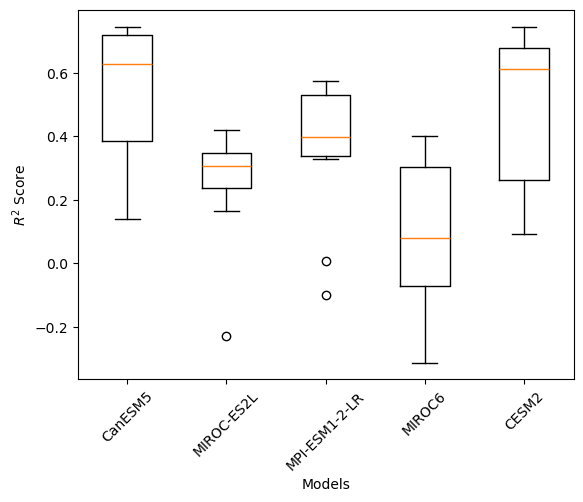

In [13]:
plt.boxplot([np.mean(scores_pattern[model], axis=1) for model in models])
# Boxplot
# Set xticklabels with alpha values
plt.xticks(range(1, len(models) + 1), [model for model in models], rotation=45)

# Set xlabel with alphas
plt.xlabel(r'Models')

# Set ylabel with r2 score
plt.ylabel(r'$R^2$ Score')

directory = '../Results'
plt.savefig(directory + "/R2_ridge_stability_coarse12.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [ ]:
model = 'MIROC6'
scores_pattern_maps = np.mean(scores_pattern[model], axis=0).reshape(len(lat), len(lon))

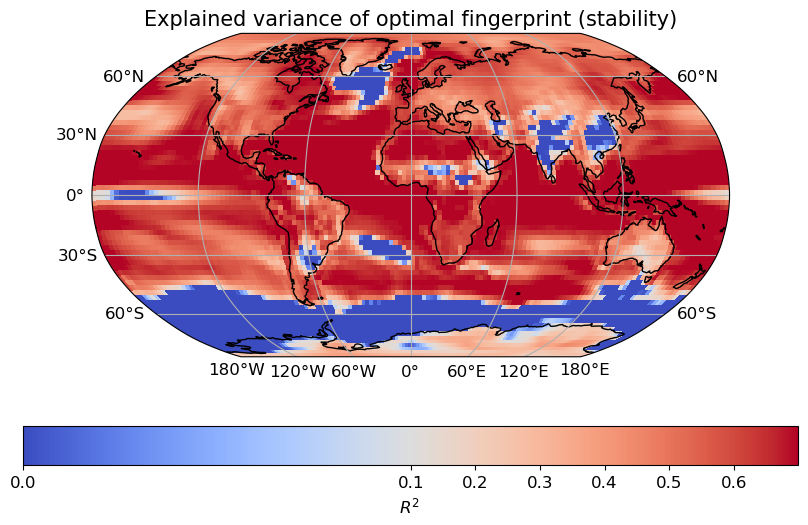

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import TwoSlopeNorm

# Assuming you have defined lat, lon, diff_r2_map, diff_corr_map, max_val_r2, max_val_corr

# Plotting
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Robinson())

# Plot for diff_r2_map
norm_r2 = TwoSlopeNorm(vmin=.0, vcenter=0.1, vmax=0.7)
contour_r2 = ax.pcolormesh(lon, lat, scores_pattern_maps, transform=ccrs.PlateCarree(), cmap='coolwarm', norm=norm_r2)
ax.coastlines()

gl = ax.gridlines(draw_labels=True)
gl.top_labels = gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}  # Longitude font size
gl.ylabel_style = {'size': 12}  # Latitude font size

ax.set_title(r'Explained variance of optimal fingerprint (stability)', fontsize=15)

cb = plt.colorbar(contour_r2, ax=ax, label='R2 score differences', orientation='horizontal')
cb.ax.tick_params(labelsize=12)
cb.set_label(r'$R^2$ ', fontsize=12) 

directory = '../Results'
plt.savefig(directory + "/maps_R2_ridge_stability_coarse_{}_{}.pdf".format(coarse, model), format="pdf", bbox_inches="tight")


plt.show()